# Comparison of driver TF ranking performance

Notebook compares the performance of RegVelo (CR), RegVelo (perturbation), and Dynamo in predicting driver genes.

## Library imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import cellrank as cr
import scanpy as sc
from regvelo import REGVELOVI

from rgv_tools import DATA_DIR, FIG_DIR
from rgv_tools.benchmarking import set_output
from rgv_tools.core import METHOD_PALETTE_DRIVER
from rgv_tools.perturbation import aggregate_model_predictions

/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packag

## Constants

In [2]:
DATASET = "hematopoiesis"

In [3]:
SAVE_DATA = True
if SAVE_DATA:
    (DATA_DIR / DATASET / "results").mkdir(parents=True, exist_ok=True)

SAVE_FIGURES = True
if SAVE_FIGURES:
    (FIG_DIR / DATASET).mkdir(parents=True, exist_ok=True)

In [4]:
Mon_driver = ["SPI1", "TCF4", "STAT6", "MEF2C"]
Ery_driver = ["NFIA", "GATA1", "TAL1", "GFI1B", "LMO2"]

In [5]:
terminal_states = ["Meg", "Mon", "Bas", "Ery"]

## Data loading

In [6]:
adata = sc.read_h5ad(DATA_DIR / DATASET / "processed" / "adata_preprocessed.h5ad")
TF = adata.var_names[adata.var["TF"]]

In [7]:
regvelo_prediction = aggregate_model_predictions(DATA_DIR / DATASET / "results")

In [9]:
HSC_Mon_ranking = pd.read_csv(DATA_DIR / DATASET / "results" / "HSC_Mon_ranking.csv", index_col=0)
HSC_Ery_ranking = pd.read_csv(DATA_DIR / DATASET / "results" / "HSC_Ery_ranking.csv", index_col=0)

## RegVelo's in silico perturbation driver identification

In [11]:
ery_auc_rgv = []
mon_auc_rgv = []

In [12]:
for coef in regvelo_prediction:
    ## ranking Erythroid drivers
    driver = Ery_driver
    cell_fate = "Ery"

    ID = set(driver).intersection(set(coef.index.tolist()))
    label = np.zeros(coef.shape[0])
    label[[i for i in range(coef.shape[0]) if coef.index.tolist()[i] in list(ID)]] = 1

    score = coef.copy().loc[:, cell_fate]
    score[np.isnan(score)] = 0
    ery_auc_rgv.append(roc_auc_score(label, (score)))

    ## ranking Monocyte drivers
    driver = Mon_driver
    cell_fate = "Mon"

    ID = set(driver).intersection(set(coef.index.tolist()))
    label = np.zeros(coef.shape[0])
    label[[i for i in range(coef.shape[0]) if coef.index.tolist()[i] in list(ID)]] = 1

    score = coef.copy().loc[:, cell_fate]
    score[np.isnan(score)] = 0
    mon_auc_rgv.append(roc_auc_score(label, (score)))

## CellRank's driver identification

In [15]:
ery_auc_cr = []
mon_auc_cr = []

## Ery driver ranking
for method in ["0", "1", "2"]:
    vae = REGVELOVI.load(DATA_DIR / DATASET / "processed" / "perturb_repeat_runs" / f"rgv_model_{method}", adata)
    set_output(adata, vae, n_samples=30, batch_size=adata.n_obs)

    ## Using CellRank identify driver
    vk = cr.kernels.VelocityKernel(adata)
    vk.compute_transition_matrix()
    ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
    g = cr.estimators.GPCCA(0.8 * vk + 0.2 * ck)
    ## evaluate the fate prob on original space
    g.compute_macrostates(n_states=6, cluster_key="cell_type")
    g.set_terminal_states(terminal_states)
    g.compute_fate_probabilities()
    df = g.compute_lineage_drivers(cluster_key="cell_type")

    df = df.loc[TF, :].copy()

    driver = Ery_driver
    cell_fate = "Ery" + "_corr"

    ID = set(driver).intersection(set(df.index.tolist()))
    label = np.zeros(df.shape[0])
    label[[i for i in range(df.shape[0]) if df.index.tolist()[i] in list(ID)]] = 1

    # Calculate AUROC
    score_raw = df.copy().loc[:, cell_fate]
    score_raw[np.isnan(score_raw)] = 0
    auroc_ery = roc_auc_score(label, (score_raw))
    ery_auc_cr.append(auroc_ery)

    ## Mon driver ranking
    driver = Mon_driver
    cell_fate = "Mon" + "_corr"

    ID = set(driver).intersection(set(df.index.tolist()))
    label = np.zeros(df.shape[0])
    label[[i for i in range(df.shape[0]) if df.index.tolist()[i] in list(ID)]] = 1

    # Calculate AUROC
    score_raw = df.copy().loc[:, cell_fate]
    score_raw[np.isnan(score_raw)] = 0
    auroc_mon = roc_auc_score(label, (score_raw))
    mon_auc_cr.append(auroc_mon)

INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/hematopoiesis/processed/perturb_repeat_runs/rgv_model_0
         /model.pt already downloaded                                                                              


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 1947/1947 [00:00<00:00, 2979.26cell/s]


Defaulting to `'gmres'` solver.


100%|██████████| 4/4 [00:00<00:00, 74.20/s]

INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/hematopoiesis/processed/perturb_repeat_runs/rgv_model_1
         /model.pt already downloaded                                                                              



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 1947/1947 [00:00<00:00, 3069.80cell/s]


100%|██████████| 4/4 [00:00<00:00, 67.83/s]

INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/hematopoiesis/processed/perturb_repeat_runs/rgv_model_2
         /model.pt already downloaded                                                                              



/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
100%|██████████| 1947/1947 [00:00<00:00, 2532.22cell/s]


100%|██████████| 4/4 [00:00<00:00, 61.69/s]


## Dynamo's driver identification

In [16]:
HSC_Ery_ranking["filter"] = [i in TF for i in list(HSC_Ery_ranking["all"])]
HSC_Mon_ranking["filter"] = [i in TF for i in list(HSC_Mon_ranking["all"])]

In [17]:
HSC_Ery_ranking = HSC_Ery_ranking.query("filter == True")
HSC_Mon_ranking = HSC_Mon_ranking.query("filter == True")

In [18]:
ID = set(Ery_driver).intersection(set(HSC_Ery_ranking.iloc[:, 0].tolist()))
label = np.zeros(HSC_Ery_ranking.shape[0])
label[[i for i in range(HSC_Ery_ranking.shape[0]) if HSC_Ery_ranking.iloc[:, 0].tolist()[i] in list(ID)]] = 1

score = -1 * np.array(range(HSC_Ery_ranking.shape[0]))
auroc_ery_dynamo = roc_auc_score(label, score)
print("AUROC:", auroc_ery_dynamo)

AUROC: 0.8888888888888888


In [19]:
ID = set(Mon_driver).intersection(set(HSC_Mon_ranking.iloc[:, 0].tolist()))
label = np.zeros(HSC_Mon_ranking.shape[0])
label[[i for i in range(HSC_Mon_ranking.shape[0]) if HSC_Mon_ranking.iloc[:, 0].tolist()[i] in list(ID)]] = 1

score = -1 * np.array(range(HSC_Mon_ranking.shape[0]))
auroc_mon_dynamo = roc_auc_score(label, score)
print("AUROC:", auroc_mon_dynamo)

AUROC: 0.6136363636363636


## Plot driver ranking results

In [ ]:
data = pd.DataFrame(
    {
        "AUROC": ery_auc_rgv + mon_auc_rgv + ery_auc_cr + mon_auc_cr + [auroc_ery_dynamo, auroc_mon_dynamo],
        "Terminal state": ["Ery"] * 3 + ["Mon"] * 3 + ["Ery"] * 3 + ["Mon"] * 3 + ["Ery", "Mon"],
        "Method": ["RegVelo (PS)"] * 6 + ["RegVelo (CR)"] * 6 + ["dynamo (LAP)"] * 2,
    }
)

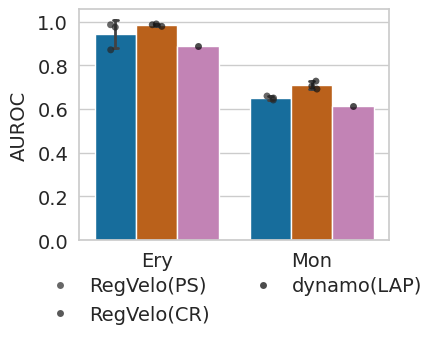

In [21]:
with mplscience.style_context():
    pal = METHOD_PALETTE_DRIVER
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(4, 3))

    sns.barplot(x="Terminal state", y="AUROC", hue="Method", data=data, ci="sd", capsize=0.1, errwidth=2, palette=pal)
    sns.stripplot(
        x="Terminal state", y="AUROC", hue="Method", data=data, dodge=True, jitter=True, color="black", alpha=0.7
    )

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[3:6], labels[3:6], bbox_to_anchor=(0.5, -0.44), loc="lower center", ncol=2, fontsize=14)

    plt.ylabel("AUROC", fontsize=14)
    plt.xlabel("", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    if SAVE_FIGURES:
        plt.savefig(FIG_DIR / DATASET / "driver_ranking.svg", format="svg", transparent=True, bbox_inches="tight")
    plt.show()